<a href="https://colab.research.google.com/github/timsetsfire/regression-from-scratch/blob/master/Exercise%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solution

In this book we'll demonstrate a method to pick the "best" $\lambda$ for $L_2$ regularization.  I say "best" because the choosen $\lambda$ will be best with regard to the way we sample the data.  

A general outline of the solution

* Split our data up into train, validation and test datasets
* Create a list of $\lambda$'s to loop through
* With each loop, we'll calc the regularized beta solution with the training data and calc the mean square error on our validation data.
* The betas corresponding to the $\lambda$ which gave the best sum of squared error will be tested on on the test data along side the OLS solution

Recall our regularized betas can be calc'd as 
$$\beta_\lambda = (X^TX + \lambda I)^{-1}X^Ty$$
and that out OLS solution is
$$\beta_{OLS} = (X^TX)^{-1}X^Ty$$

$I$ is an n by n identity matrix, where n is the number of features in $X$.

If you don't standardize your data, you must add a bias.  Since we don't want to regularize the bias set $I_{1,1} = 0$ (this is the top left most entry - I'm not starting my indexing with 0's)

The mean square error (MSE) will be our cost function

$$ MSE = \frac{1}{m}(y - X\beta)^T(y-X\beta)$$

with $m$ equal to the number of observations

In [1]:
from sklearn.model_selection import train_test_split  # used to split up out data
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler # used to standardize data
import numpy as np 
import seaborn as sns # my favorite plotting tool
from pandas import DataFrame 

In [2]:
lin_reg_data = load_diabetes(return_X_y = False)

In [3]:
X = lin_reg_data.data
X = np.matrix(X)
y = lin_reg_data.target
y = np.matrix(y).T

In [100]:

## split our data into three sets: training, validation and test
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.3, random_state = 42)

## create StandardScalers to standardize both X and y
ss_x = StandardScaler()  
ss_y = StandardScaler()

## fit the standardizer on the training data. 
ss_x.fit(X_train)  
ss_y.fit(y_train)

## standardize all the data 
## and cast everything as a matrix 
X_train = np.matrix(ss_x.transform(X_train))
X_val = np.matrix(ss_x.transform(X_val))
X_test = np.matrix(ss_x.transform(X_test))

y_train = np.matrix(ss_y.transform(y_train))
y_val = np.matrix(ss_y.transform(y_val))
y_test = np.matrix(ss_y.transform(y_test))

## get the number of observations and features
m,n = X_train.shape

## create the identity matrix
I = np.eye(n)

# calc the largest lambda (just a rule of thumb calculation)
reg = np.max( np.fabs( X_train.T*y_train)/m)/1e-3
best_lambda = reg
best_error = np.Infinity

## create list of lambdas to loop through
lambdas = np.exp(np.linspace(-10,np.log(reg),100))

## initialize list to store the sum of squared errors for each loop
sses = []
for reg in lambdas:
    b = np.linalg.inv( X_train.T*X_train + reg*I)*X_train.T*y_train
    error = ((y_val - X_val*b).T * (y_val - X_val*b))/X_val.shape[0]
    sses.append(error[0,0])
    if error[0][0] < best_error:
        best_error = error[0,0]
        best_lambda = reg
    #print("{: <8} \t {}".format(np.round(reg,6),error[0,0]))
print("best error and lambda: ", best_error, best_lambda)

best error and lambda:  0.46817964308514426 69.87575351793703


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


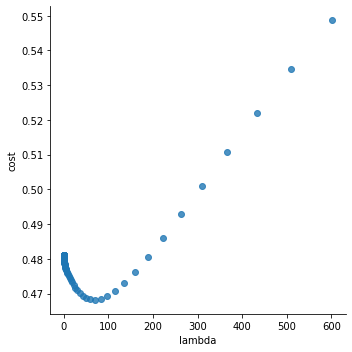

In [101]:
cv = DataFrame([lambdas, sses]).T
cv.columns = ["lambda", "cost"]
sns.lmplot('lambda','cost',cv,fit_reg=False)

The plot above is based on the validation data.  The $x$ axis is the $lambda$, i.e., how much we penalize our cost function, and the $y$ axis is the average sum of squared errors for each corresponding $\lambda$.  Moving from left to right, we are increasing our penality.  It's interesting - the OLS solution corresponds to $\lambda = 0$, but our regularized solution with $lambda \approx 36$ performs best.  

Our choices to this point have been independent of the test data, so let's test how well our regularized beta measures up against the OLS beta by calc the mean square error for the test data set with each parameter set.

In [102]:
reg = best_lambda
# calculate the betas on the training data
b = np.linalg.inv( X_train.T*X_train + reg*I)*X_train.T*y_train
b_ols = np.linalg.inv(X_train.T*X_train)*X_train.T*y_train

# calc errors on the test data
error = (y_test - X_test*b).T*(y_test - X_test*b) / X_test.shape[0]
error_ols = (y_test - X_test*b_ols).T*(y_test - X_test*b_ols) / X_test.shape[0]
print("results on test data")
print("regularized b results in cost: ",error[0,0])
print("ols b results in cost: {}".format(error_ols[0,0]))


results on test data
regularized b results in cost:  0.4524548975266446
ols b results in cost: 0.44118039340128457


Our regularized solution outperforms the OLS solution.  Keep in mind that if you change the seed in the test_train_split, you will get a different story. 

## Exercise 2 

Add regularization to Gradient Descent

Note that when we add regularization to Gradient Descent -> the best lambda is going to be different from the one in the previous exercise.  

In [115]:
## create the objective function 

class MSE(object):
    def valueAt( x, y, beta):
        yhat = x * beta
        e = y - yhat
        return e.T*e / x.shape[0]
    def gradientAt(x, y, beta):
        yhat = x * beta
        e = y - yhat
        return -x.T*e / x.shape[0]
  
class L2(object):
    def valueAt(b):
        return 1/2*linalg.norm(b) 
    def gradientAt(b):
        return b
    
class GradientDescent(object):
    def __init__(self, cost_function=MSE, tolerance=1e-6, penalty_function = L2, regularization=None):
        self.cost_function = cost_function
        self.penalty_function = penalty_function
        self.tol = tolerance
        self.iter = 0
        self.beta = None
        self.regularization = regularization
        
    def optimize(self, X,y,learning_rate=0.1,init_params=None):
        if init_params is None:
            beta = np.matrix( np.zeros(X.shape[1])).T
        else:
            beta = init_params
        grad = self.cost_function.gradientAt(X,y,beta)
        if self.regularization is not None:
            ## new line
            grad += self.regularization * self.penalty_function.gradientAt(beta)
        prev_beta = beta
        beta = beta - learning_rate*grad
        ## several termination criteria to use
        ## abs change in beta is small
        ## abs change in beta / norm of beta 
        ## abs change in object is small
        ## here we use magitute of the gradient
        while np.linalg.norm(prev_beta - beta)/np.linalg.norm(beta) > self.tol:
            prev_beta = beta
            self.iter += 1
            grad = self.cost_function.gradientAt(X,y,beta)
            if self.regularization is not None:
              ## new line
              grad += + self.regularization * self.penalty_function.gradientAt(beta)
            beta = beta - learning_rate*grad
        self.beta = beta
        return beta

In [135]:
linear_regression = GradientDescent(regularization = 0.1)
parameters = ["bias"]
parameters.extend( ["x{}".format(i) for i in range(X.shape[1]-1)])
sbeta_gd = linear_regression.optimize(X_train,y_train,learning_rate=0.1)
DataFrame( np.concatenate( (b_ols, sbeta_gd),axis=1),
          index = parameters,
          columns = ["b_ols", "gd beta"])

,b_ols,gd beta
bias,0.005077,0.012528
x0,-0.155420,-0.135430
x1,0.342506,0.321547
x2,0.184195,0.173203
x3,-0.614662,-0.079114
x4,0.351174,-0.060027
x5,0.115964,-0.114155
x6,0.169882,0.102929
x7,0.502954,0.269117
x8,0.023705,0.038443


In [136]:
MSE.valueAt(X_val, y_val, sbeta_gd)

matrix([[0.47136222]])

In [137]:
MSE.valueAt(X_val, y_val, b_ols)

matrix([[0.4811709]])